# A semi-comprehensive tour for Deep Learning with Tensorflow

In [1]:
import sys
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from data import Data
import os
import pandas as pd
import numpy as np
from sklearn.metrics import auc, confusion_matrix
from matplotlib import pyplot as plt
import datetime
import plot_function # just loads some pyplot parameters to make the plots up to the scientific standards.

import tensorboard
#from tb_cscs import tensorboard #to use tensorboard on CSCS

2023-08-18 10:19:57.787170: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-18 10:19:57.918090: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon/projects/py_IPOPT/Ipopt-3.12.5/build/lib:
2023-08-18 10:19:57.918110: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-18 10:19:58.529073: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinf

## Set-up of notebook
* how to create a model
* how to train a model
* how to measure performance
* a simple regression example
* a complex regression example
* a simple classification example
* a complex classification example
* a "real-world" classification example with data from [Lending Club](https://www.lendingclub.com/)

A. Didisheim, S. Scheidegger, 02/21

In [2]:
def create_model(
        data,
        learning_rate=0.005,
        opti='adam', # you can put 'adam', 'sgd', or 'rms_prop'
        batch_normalization=False,
        activation='relu', # 'sigmoid', or 'relu' are the main two, but others are coded in keras (see documentation)
        architecture=[64, 32, 16], # each number correspond to a number of neurons in a layer
        verbose=0):

    # check that the input are correct
    assert type(architecture) == list, 'architecture must be a list of integers (e.g. [64,32,16], each representing a number of neurones in a layer'
    assert opti in ['adam','sigmoid','rms_prop'], "invalid optimizer, please chose among ['adam','sigmoid','rms_prop']"
    assert type(data) == Data, 'the data object must come from the "Data" class'

    # extract the input shape and output shape from the data
    input_dim = data.X_te.shape[1]
    output_dim = data.y_te.shape[1]

    # build the network
    L = []
    for i, l in enumerate(architecture):
        if i == 0:
            L.append(layers.Dense(l, activation=activation, input_shape=[input_dim])) # add the first layer
        else:
            L.append(layers.Dense(l, activation=activation)) # add a layer
        if batch_normalization:
            # add batch normalization if specified
            L.append(layers.BatchNormalization())

    # add the final layer
    if output_dim == 1:
        L.append(layers.Dense(output_dim))
    else:
        # if we are doing classification, we wish to normalize the ouput between 0 and 1, hence the softmax
        L.append(layers.Dense(output_dim, activation='softmax'))

    # keras command to build a simple feed forward network with the parameters defined above
    model = keras.Sequential(L)

    # select the optimizer
    if opti == 'sgd':
        optimizer = tf.keras.optimizers.SGD(learning_rate)
    if opti == 'rms_prop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    if opti == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate)

    ##################
    # define an additional metrics
    ##################
    if output_dim == 1:
        # here we do a regression---that, is we predict one continous thing, hence we can add the R squared as a metric
        def r_square(y_true, y_pred):
            SS_res = tf.reduce_sum(tf.square(y_true - y_pred))
            SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
            return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

        # we have three metrics:
        # mean absolute error -> mae
        # mean square error -> mse
        # and our custom r-square.
        model.compile(loss='mae', optimizer=optimizer, metrics=['mae', 'mse', r_square])
    if output_dim > 1:
        # here we do a classifier ---that, is we predict a percentage of being in one dimension instead of another
        # we have two  metrics:
        # mean absolute error -> mae
        # accracy
        model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False), optimizer=optimizer, metrics=['accuracy', 'mae'])
    if verbose:
        # if specified, print the network architecture
        print(model.summary())
    return model


def train_model(model, data, epoch=10, bs=256, verbose=0, tensor_board_name = None):
    assert type(data) == Data, 'the data object must come from the "Data" class'
    tf.random.set_seed(1234)
    np.random.seed(1234)
    print('### start training for', epoch, 'epochs')
    # Prepare the validation dataset
    val_dataset = tf.data.Dataset.from_tensor_slices((data.X_va, data.y_va))
    val_dataset = val_dataset.batch(256)

    if tensor_board_name is not None:
        # set_up the tensorboard name

        log_dir = "logs/"+tensor_board_name#+"/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
        history_training = model.fit(x=data.X_tr, y=data.y_tr, batch_size=bs, epochs=epoch, validation_data=val_dataset, verbose=verbose, callbacks=tensorboard_callback)

    else:
        # the keras command to launch the training routine
        history_training = model.fit(x=data.X_tr, y=data.y_tr, batch_size=bs, epochs=epoch, validation_data=val_dataset, verbose=verbose)
    print('### training finish \n')

    # return the history of training process
    return pd.DataFrame(history_training.history)


def show_performance(label_, model, history_training, data):
    assert type(data) == Data, 'the data object must come from the "Data" class'

    # check the output_dim to calibrate the plot
    output_dim = data.y_te.shape[1]

    # use the pandas function to start the plot (history training is a PD data frame).
    history_training[['loss', 'val_loss']].plot()
    plt.grid(True)  # add a grid for visibiliy
    plt.xlabel('epochs')
    if output_dim == 1:
        plt.ylabel('mean absolute error')  # if its a regression, we plot the mae
    else:
        plt.ylabel('cross entropy loss')   # if its a classification, we plot the cross entropy loss
    plt.title(label_)
    plt.savefig(label_+'.png')
    plt.show()

    if output_dim == 1:
        # if regression, compute the out of sample performance measure
        print('=' * 50)
        print('Out of sample performance:')
        model.evaluate(data.X_te, data.y_te, verbose=2)
        print('=' * 50)

    else:
        # if classification  print the  confusion matrix
        pred = model.predict(data.X_te)
        cf = confusion_matrix(y_true=np.argmax(data.y_te, 1), y_pred=np.argmax(pred, 1))
        cf = pd.DataFrame(cf)
        index = ['True ' + str(x) for x in cf.index]
        col = ['Predicted ' + str(x) for x in cf.columns]
        cf.index = index
        cf.columns = col
        print(cf)

## Simple Regression

* `N` is tha sample size. 
* `D` is the dimension of input. 
* `L` is a measure of complexity of the function to estimate, output_dim is the output dimension.
* `output_dim = 1` means we do a regression, output_dim >1 means we do a classification exercise.



Simple Regression



2023-08-18 10:20:26.392685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon/projects/py_IPOPT/Ipopt-3.12.5/build/lib:
2023-08-18 10:20:26.392755: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-18 10:20:26.392818: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (simon-ThinkPad-X1-Carbon-6th): /proc/driver/nvidia/version does not exist
2023-08-18 10:20:26.396498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

### start training for 20 epochs
### training finish 



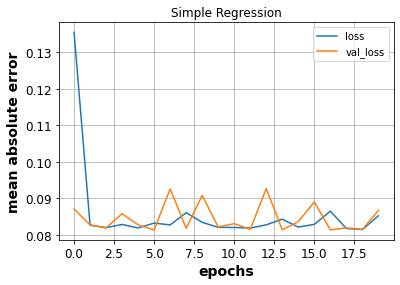

Out of sample performance:
16/16 - 0s - loss: 0.0818 - mae: 0.0818 - mse: 0.0105 - r_square: 0.9888 - 108ms/epoch - 7ms/step


In [3]:
data = Data()

n = 'Simple Regression'
print('\n' + '=' * 50)
print(n)
print('=' * 50, '\n')

data.gen_random_data(N=10 * 1000, D=10, LL=[20,20], output_dim=1, sigma=0.1)

model = create_model(data=data, learning_rate=0.005, opti='adam', batch_normalization=False, activation='relu', architecture=[64, 32], verbose=0)
history = train_model(model, data, epoch=20, verbose=0)
show_performance(n, model, history, data)



## Complex Regression

* `N` is tha sample size. 
* `D` is the dimension of input. 
* `L` is a measure of complexity of the function to estimate.
* `output_dim` is the output dimension. output_dim = 1 means we do a regression, output_dim >1 means we do a classification exercise.



Complex Regression

### start training for 20 epochs
### training finish 



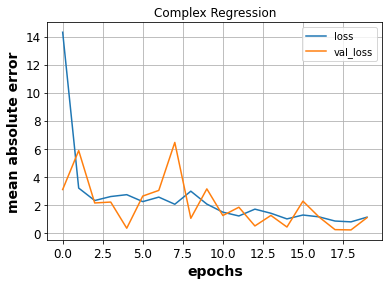

Out of sample performance:
16/16 - 0s - loss: 0.9854 - mae: 0.9854 - mse: 2.2151 - r_square: -1.2263e+00 - 111ms/epoch - 7ms/step


In [4]:
n = 'Complex Regression'
print('\n' + '=' * 50)
print(n)
print('=' * 50, '\n')

data.gen_random_data(N=10 * 1000, D=10, LL=[200,200,200,200], output_dim=1, sigma=0.1)
# TODO try to add one layer and see if performance improve
model = create_model(data=data, learning_rate=0.005, opti='adam', batch_normalization=False, activation='relu', architecture=[64,32], verbose=0)
history = train_model(model, data, epoch=20, verbose=0)
show_performance(n, model, history, data)

## Simple Classification

* `N` is tha sample size. 
* `D` is the dimension of input. 
* `L` is a measure of complexity of the function to estimate.
* `output_dim` is the output dimension. output_dim = 1 means we do a regression, output_dim >1 means we do a classification exercise.




Simple Classification

### start training for 20 epochs
### training finish 



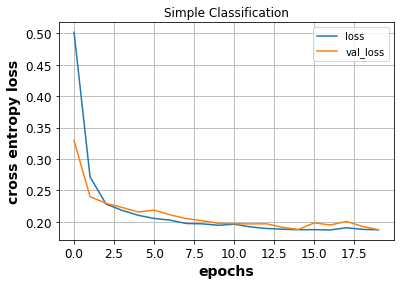

16/16 [==============================] - 0s 925us/step
        Predicted 0  Predicted 1  Predicted 2
True 0          153           14            3
True 1           13          154            6
True 2           11            7          139


In [5]:
n = 'Simple Classification'
print('\n' + '=' * 50)
print(n)
print('=' * 50, '\n')


data.gen_random_data(N=10 * 1000, D=10, LL=[20,20], output_dim=3, sigma=0.1)

model = create_model(data=data, learning_rate=0.005, opti='adam', batch_normalization=False, activation='relu', architecture=[64,32], verbose=0)
history = train_model(model, data, epoch=20, verbose=0)
show_performance(n, model, history, data)


## Complex Classification
* `N` is tha sample size.
* `D` is the dimension of input.
* `L` is a measure of complexity of the function to estimate.
* `output_dim` is the output dimension
* output_dim = 1 means we do a regression, output_dim >1 means we do a classification exercise


Complex  Classification

### start training for 20 epochs
### training finish 



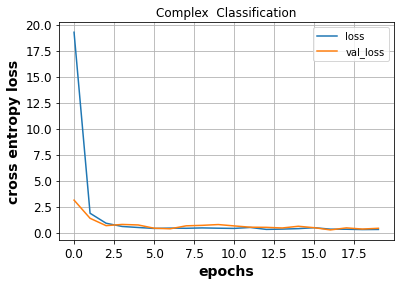

16/16 [==============================] - 0s 811us/step
        Predicted 0  Predicted 1  Predicted 2
True 0          135           36            2
True 1            1          165            1
True 2            6           31          123


In [6]:
n = 'Complex  Classification'
print('\n' + '=' * 50)
print(n)
print('=' * 50, '\n')

data.gen_random_data(N=10 * 1000, D=10, LL=[200,200,200,200], output_dim=3, sigma=0.1)
# TODO try re-runing the same result with a three layer architecture [64,16,32] and a larger sample
model = create_model(data=data, learning_rate=0.005, opti='adam', batch_normalization=False, activation='relu', architecture=[64,32], verbose=0)
history = train_model(model, data, epoch=20, verbose=0)
show_performance(n, model, history, data)

## Lending Club data

* The Lending Club (https://www.lendingclub.com/) is a peer-to-peer lending website. On this platform, an individual borrower can ask for loans, and the individual lender (anyone with some money) can decide or not to lend them money. 

* The interest rate charged by the lender to the borrower is defined by a rating (from A to G). This grade is assigned by a secret algorithm which takes as input the lender's characteristics (history of credit, revenue, assets, etc.) and give as output a grade. 

* The LendingClub published data containing the rating and some of the input characteristics of the lender and the  data have been collected by the website Kaggle (https://www.kaggle.com/wendykan/lending-club-loan-data).

* The example below uses a subset of the full data set to make the model training quicker. The aim is to use a neural network to estimate the rating from the lender's input. In other words, use a neural network to estimate the proprietary algorithm used by the lending club. 


Lending Club data

### start training for 5 epochs
Epoch 1/5


2023-08-18 10:20:39.268502: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 77760000 exceeds 10% of free system memory.


528/528 [==============================] - 2s 2ms/step - loss: 0.3176 - accuracy: 0.4163 - mae: 0.1915 - val_loss: 0.3065 - val_accuracy: 0.4269 - val_mae: 0.1874
Epoch 2/5
528/528 [==============================] - 1s 2ms/step - loss: 0.3064 - accuracy: 0.4294 - mae: 0.1874 - val_loss: 0.3052 - val_accuracy: 0.4292 - val_mae: 0.1860
Epoch 3/5
528/528 [==============================] - 1s 2ms/step - loss: 0.3053 - accuracy: 0.4320 - mae: 0.1867 - val_loss: 0.3048 - val_accuracy: 0.4291 - val_mae: 0.1873
Epoch 4/5
528/528 [==============================] - 1s 2ms/step - loss: 0.3046 - accuracy: 0.4329 - mae: 0.1863 - val_loss: 0.3045 - val_accuracy: 0.4311 - val_mae: 0.1869
Epoch 5/5
528/528 [==============================] - 1s 2ms/step - loss: 0.3042 - accuracy: 0.4340 - mae: 0.1860 - val_loss: 0.3040 - val_accuracy: 0.4334 - val_mae: 0.1862
### training finish 



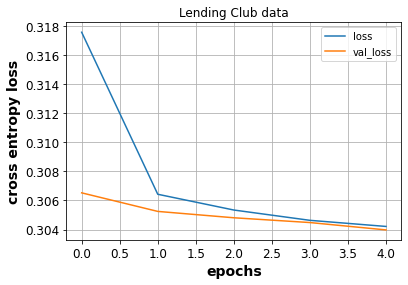

938/938 [==============================] - 1s 704us/step
        Predicted 0  Predicted 1  Predicted 2  Predicted 3  Predicted 4  \
True 0         3197         2249          403            3            0   
True 1         1445         5034         2833           78            0   
True 2          461         3025         4222          455            0   
True 3           96          946         2572          552            0   
True 4           29          336         1047          317            0   
True 5            7           64          353          133            0   
True 6            2           13           68           60            0   

        Predicted 5  Predicted 6  
True 0            0            0  
True 1            0            0  
True 2            0            0  
True 3            0            0  
True 4            0            0  
True 5            0            0  
True 6            0            0  


In [7]:
data_untared= False
if os.path.exists('./data'):
    if ('LCy.csv' in os.listdir('./data')) & ('LCx.csv' in os.listdir('./data')) :
        data_untared = True

if data_untared:
    ##################
    # Lending club data
    ##################
    # Here we take a real example using data from the lending club https://www.lendingclub.com/
    # The X contains characteristics of prospective borrowers (FICO score, number of credit cards etc)
    # The data have already been simplified and normalized for you
    # The y contains data binary variable with the grades of each loan. The first columns correspond to a grade A (best) and the last to a grade of G (worst)

    n = 'Lending Club data'
    print('\n' + '=' * 50)
    print(n)
    print('=' * 50, '\n')

    data.load_lending_club_data()
    # TODO, can a different architecture and number of epoch significantly improve performance with these real data? If you find something great, I am interrested ;)
    model = create_model(data=data, learning_rate=0.005, opti='adam', batch_normalization=False, activation='relu', architecture=[64,32], verbose=0)
    history = train_model(model, data, epoch=5,bs=1024, verbose=1, tensor_board_name='LC')
    show_performance(n, model, history, data)
else:
    print('!!!! To test the lending club data, first untar the data folder')
    print('To do so, run the follwing line in the terminal')
    print('tar -xzvf data.tar.gz')



Once the model is trained, we can use it to make predictions. 



In [8]:
if data_untared:
    pred = model.predict(data.X_te)
    print(pred)
    

938/938 [==============================] - 1s 678us/step
[[7.2602832e-01 1.8733367e-01 6.8258204e-02 ... 4.1591865e-03
  9.3967764e-04 1.8557240e-04]
 [5.4292683e-02 6.9302934e-01 2.1339431e-01 ... 5.7596839e-03
  7.4604683e-04 4.9875198e-05]
 [4.3231842e-01 4.4268778e-01 1.0442189e-01 ... 3.6844991e-03
  6.4825418e-04 5.6875095e-05]
 ...
 [2.2543394e-03 7.6165669e-02 3.9862579e-01 ... 1.2722638e-01
  3.9686169e-02 1.4240539e-02]
 [3.2488707e-01 4.8548874e-01 1.5730672e-01 ... 5.8290740e-03
  9.8247314e-04 2.2380025e-04]
 [6.2533122e-01 2.6992226e-01 8.1187256e-02 ... 5.7443460e-03
  1.1137107e-03 2.3228710e-04]]


* The output matrix contains the nnet predicted probabilities that each observation belong to each possible rating. 
* For some, a matrix of probability may be hard to read or interpet. 

* In the following cell we look at the first 10 observations in the test sample. We plot the nnet-predicted probabilities that each observation belong to a particular rating. The red columns indicate the true grades obtained by the borrower. 

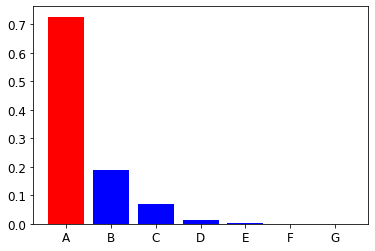

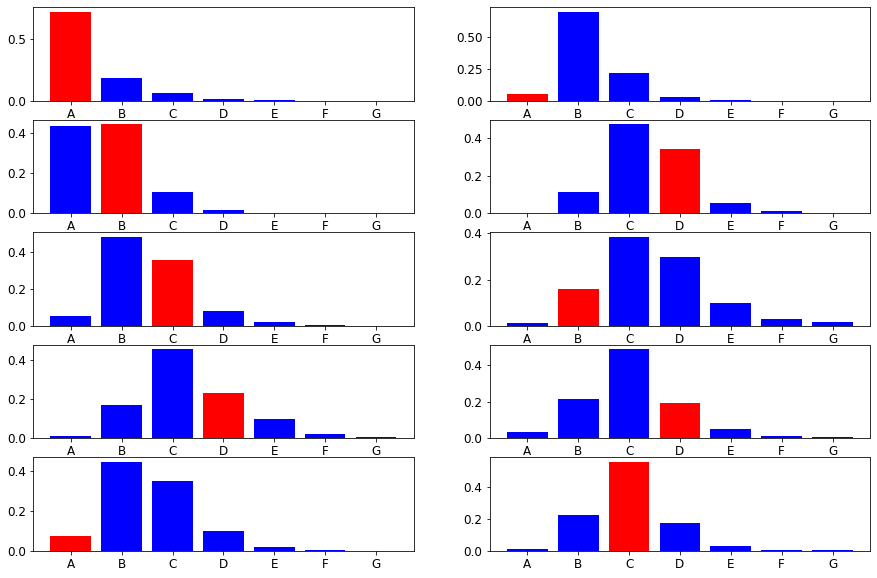

In [9]:
if data_untared:
    def bar_plot(i):
        pr_i = pred[i,:]
        true_i = data.y_te[i,:]
        col=pd.Series(true_i).map({0:'b', 1:'r'}).values
        rating = ['A','B','C','D','E','F','G']
        plt.bar(rating, pr_i,color=col)
    bar_plot(0)
    
    plt.figure(figsize=(5*3,2*5))
    for i in range(10):
        plt.subplot(5,2,i+1)
        bar_plot(i)
    
    plt.show()

## Tensorboard
To improve performance, the first thing to do would be to use the full sample. In addition, the model should probably be tuned. 
Proper tuning requires access to some information about the training process. 

Tensorboard is a tool that saves information about the model during the training process and allows you to visualize it while the model run and after. 

When creating the model we used the line: 
history = train_model(model, data, epoch=5,bs=1024, verbose=1, tensor_board_name='LC')

The last parameter of the train_model function gave a name to the directory to store the Tensorboard data. 

To launch Tensorboard use the command: 
tensorboard --logdir logs/LC

#### Tensorboard on Nuvolos
On Nuvolos, those additional commands need to be 

jupyter tensorboard enable --user

There is the possibility that the tensorboard launcher is throwing "404: Not Found" errors. If this is the case, hitting the command

jupyter tensorboard enable --user

and restarting the application should solve the issue. 


In [10]:
tensorboard.notebook.list()

No known TensorBoard instances running.


In [11]:
%reload_ext tensorboard

In [12]:
%tensorboard --logdir logs/LC --host "127.0.0.1"

Launching TensorBoard...

KeyboardInterrupt: 